##  Optimze and a Dense Neural Network for gap filling and feature identification

** With a few tweaks to RepRunner, an LSTM can be run instead

In [63]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
# from functools import partial
from multiprocessing import Pool
from functools import partial
from sklearn import metrics
# from sklearn.model_selection import train_test_split

## Personal Modules
import ReadStandardTimeFill as RSTF
import importlib
import DenseNet as Dense
import MiscFuncs as MF
importlib.reload(Dense)
importlib.reload(RSTF)
importlib.reload(MF)

# %matplotlib inline

%matplotlib notebook
%config IPCompleter.greedy=True

from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from sklearn.externals import joblib
from matplotlib import cm

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

from ipywidgets import FloatProgress, HTML
from IPython.display import display, clear_output
import os  
import shutil
from keras import backend as K
try:pool.close()
except:pass


def Test(params,X,y,YScaled,XScaled,pool):
    return(np.random.rand(params['K']))


def ModSelect(Scope,Site):
    if Site == 'Illisarvik':
        if Scope == 'Full':
#             Model = ['wind_speed','PPFD_Avg','AirTC_Avg','VPD',
#                     'Temp','VWC','Sedge','Shrub','Grass','Upland']
            Model = ['wind_speed','PPFD_Avg','AirTC_Avg','VPD',
                    'Temp','VWC','Sedge','Shrub','Grass','Out_of_Basin']
        if Scope == 'Test':
            Model = ['PPFD_Avg','Upland','wind_speed']
    if Site == 'FishIsland':
        BaseFactors = []
        if Scope == 'Full':
            Model = ['Wind Spd','u*','air pressure','Ta','VPD','Rn','PPFD','Water Table','Active Layer',
         'Ts 2.5 cm Cent','Ts 5 cm Cent','Ts 15 cm Cent','Ts 2.5 cm Rim','Ts 5 cm Rim','Ts 15 cm Rim','VWC']
#             'H','LE','24H Rain','Ts All Cent','Ts All Rim','VWC',
        if Scope == 'Test':
            Model = ['Wind Spd','Ta','Rn','PPFD','Water Table',
            'Ts 2.5 cm','Ts 15 cm','VWC','Active Layer','24H Rain']
    return(Model)

def Combos(Model,L,factor=None):
    Models=[]
    for c in combinations(Model,L):
        c = list(c)
        if factor is None:
            Models.append(c)
        else:
            for f in factor:
                f = f.split('+')
                if set(f).issubset(set(c)) and c not in Models:
                    Models.append(c)
                    
#     print('Models: ',Models)
    return(Models)

def Stats(mse,se,j,i,params):
    df = pd.DataFrame(index = [str(j)+'_'+str(i)],
                      data={'Model':[params['Model']],
                            'MSE':[mse],
                            'Size':j,
                            'Number':i,
                            'SE':[se],
                            'Performance':0})
    return(df)

def t(p,n):
    alpha = 1-p
    df = n-1
    return(stats.t.ppf(alpha,df))

FirstRun = True
# FirstRun = False

MP=True
# MP=False
Scope = 'Full'
# Scope = 'Test'
# if Scope == Test:
#     processes=2
# else:
processes=3
    
cwd = os.getcwd()
# for Site in ['Illisarvik','FishIsland']:
# Site='FishIsland'
Site = 'Illisarvik'
target='fch4'
alpha = .05
print(cwd)


pd.set_option('max_colwidth',200)
def Display (tar,prog1,prog2,MdLs,MdL):
    clear_output()
    display(tar)
    display(prog1)
    display(prog2)
    display(MdLs)
    display(MdL)
    
tar = HTML(
            value=" ",
            placeholder='Target: ',
            description='Target: ',
        )
kwt = HTML(
        value=str(0),
        placeholder='Quit Score: ',
        description='Quit Score: ',
        )
print(':o')

C:\Users\wesle\NetworkAnalysis
:o


# Model

In [70]:
from sklearn.utils import resample
prog1 = FloatProgress(min=1, max=2,description='Running:')
prog2 = FloatProgress(min=0, max=100,description='Bootstrapping:')
MdLs = HTML(
    value=" ",
    placeholder='Models: ',
    description='Models: ',
)
MdL = HTML(
    value=" ",
    placeholder='Testing: ',
    description='Testing: ',
)
Display (tar,prog1,prog2,MdLs,MdL)

i = 1
j = 1
target = 'fco2'
Name ='ER'
tar.value=target

params = Dense.Params(Scope,target,MP)
# params['K']=15
params['Dpath'] = cwd+'/'+Site+'/'
params['Spath'] = params['Dpath']+Name+'/'+str(j)+'_'+str(i)+'/'
try:
    os.mkdir(params['Spath'])
except:
    pass
params['Sname'] = 'Y_'
# params['Inputs'] = ['PPFD_Avg','VPD']#Input
# params['Inputs'] = ['PPFD_Avg','VPD','VWC','Shrub']#Input

params['Inputs'] = ['PPFD_Avg','VPD','VWC','Shrub']

MdL.value='#'+str(i)+' '+str(params['Inputs'])
Display (tar,prog1,prog2,MdLs,MdL)
params['Model'] = '+'.join(params['Inputs'])
RST = RSTF.ReadStandardTimeFill(params,'ECData.csv')#,resample='2H')


# plt.figure()
# plt.plot(RST.Master['VPD'])
# print(RST.Master[['VWC','Shrub','VPD']][20:50])

# if Name =='ER':
#     RST.Master = RST.Master.loc[RST.Master['fco2']>.05]
if Name =='ER':
    RST.Master = RST.Master.loc[(RST.Master['PPFD_Avg']<10)]#&(RST.Master['fco2']>.0)]

# print(RST.Master['fco2'])
# print(RST.Master.sort_values(by='fco2')['fco2'])


RST.Master = resample(RST.Master, n_samples=int(RST.Master.shape[0]*1.5))

RST.Scale(params['target'],params['Inputs']) 
y_Set = RST.y*1.0
X_Set = RST.X*1.0


print(params)
# print(RST.Master['fco2'].mean())
# print(RST.Master['fco2'].mean()*1e-6 * 44.0095 *3600*24)
# if MP == False:
#     for k in range(1):

HTML(value='fco2', description='Target: ', placeholder='Target: ')

FloatProgress(value=1.0, description='Running:', max=2.0, min=1.0)

FloatProgress(value=0.0, description='Bootstrapping:')

HTML(value=' ', description='Models: ', placeholder='Models: ')

HTML(value="#1 ['PPFD_Avg', 'VPD', 'VWC', 'Shrub']", description='Testing: ', placeholder='Testing: ')

{'proc': 3, 'K': 30, 'epochs': 1000, 'target': 'fco2', 'Save': {'Weights': True, 'Model': True}, 'Loss': 'mean_squared_error', 'Memory': 0.3, 'validation_split': 0.2, 'iteration': 1, 'Eval': True, 'Dpath': 'C:\\Users\\wesle\\NetworkAnalysis/Illisarvik/', 'Spath': 'C:\\Users\\wesle\\NetworkAnalysis/Illisarvik/ER/1_1/', 'Sname': 'Y_', 'Inputs': ['PPFD_Avg', 'VPD', 'VWC', 'Shrub'], 'Model': 'PPFD_Avg+VPD+VWC+Shrub'}


In [71]:

params['N']=int(y.shape[0]/30)
params['Memory'] = (math.floor(100/params['proc'])- 5/params['proc']) * .01
Y_hat=[]
y_true=[]
X_true=[]
index=[]
ones=[]
prog2.value=0
if MP == False:
    for k in range(params['K']):
        Time2 = time.time()
        results = Dense.Bootstrap(k,params,X,y)
        Y_hat.append(RST.YScaled.inverse_transform(results[0]))
        y_true.append(RST.YScaled.inverse_transform(results[1]))
        X_true.append(RST.XScaled.inverse_transform(results[2]))
        ones.append(results[3])
        prog2.value=(k+1)/params['K']*100
        print(time.time()-Time2)
else:
    pool = Pool(processes=processes,maxtasksperchild=75)
    for k,results in enumerate(pool.imap(partial(Dense.Bootstrap,params=params,X=X,y=y),
                                         range(0,params['K']))):
        Y_hat.append(RST.YScaled.inverse_transform(results[0]))
        y_true.append(RST.YScaled.inverse_transform(results[1]))
        X_true.append(RST.XScaled.inverse_transform(results[2]))
        ones.append(results[3])
        prog2.value=(k+1)/params['K']*100
    pool.close()
Y_hat = np.squeeze(np.asanyarray(Y_hat))
y_true = np.squeeze(np.asanyarray(y_true))
X_true = np.asanyarray(X_true)
ones = np.asanyarray(ones)
params['Memory'] = .95
mse,se = Dense.Sort_outputs(k,params,Y_hat,y_true,X_true,ones)
    
Level = Stats(mse,se,j,i,params)
Level.to_csv(params['Dpath']+Name+'.csv')


print(Level)

C:\Users\wesle\NetworkAnalysis\DenseNet.py:144: RuntimeWarning: Mean of empty slice
  


Var!!
[[0.10037048]
 [0.14925822]
 [0.10700432]
 [0.11120901]
 [0.10173358]
 [0.1432603 ]
 [0.10567676]
 [0.11418499]
 [0.10996719]
 [0.20785347]
 [0.1       ]
 [0.11370051]
 [0.1054191 ]
 [0.26845134]
 [0.10212154]
 [0.10049568]
 [0.10469609]
 [0.1054191 ]
 [0.10075454]
 [0.10173358]
 [0.29419924]
 [0.1194887 ]
 [0.11075041]
 [0.16472995]
 [0.13302275]
 [0.10087181]
 [0.10726029]
 [1.        ]
 [0.10116927]
 [0.12253015]
 [0.1194887 ]
 [0.10466812]
 [0.10111101]
 [0.1054191 ]
 [0.10008137]
 [0.10663015]
 [0.14925822]
 [0.1134009 ]
 [0.10633174]
 [0.10339518]
 [0.17360503]
 [0.10087181]
 [0.10067665]
 [0.24165065]
 [0.10213011]
 [0.20785347]
 [0.10213011]
 [0.10029438]
 [0.11797739]
 [0.11922525]
 [0.11622243]
 [0.10469608]
 [0.17360503]
 [0.10249297]
 [0.10249297]
 [0.11370051]
 [0.1059987 ]
 [0.2024558 ]
 [0.1054191 ]
 [0.13444065]
 [0.29419924]
 [0.52579415]
 [0.10466812]
 [0.11120901]
 [0.10116927]
 [0.10306368]
 [0.10551807]
 [0.10212154]
 [0.12961035]
 [0.15265683]
 [0.12961035]


C:\Anaconda3\lib\site-packages\keras\callbacks.py:543: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):
C:\Anaconda3\lib\site-packages\keras\callbacks.py:436: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current, self.best):


Epoch 3/1000
137/137 [==============================] - 0s 114us/step - loss: 842.5316 - val_loss: 198.7681
Epoch 4/1000
137/137 [==============================] - 0s 114us/step - loss: 472.5640 - val_loss: 137.2959
Epoch 5/1000
137/137 [==============================] - 0s 0us/step - loss: 322.5151 - val_loss: 108.2724
Epoch 6/1000
137/137 [==============================] - 0s 0us/step - loss: 254.5696 - val_loss: 91.5347
Epoch 7/1000
137/137 [==============================] - 0s 0us/step - loss: 228.3635 - val_loss: 80.7141
Epoch 8/1000
137/137 [==============================] - 0s 114us/step - loss: 196.0941 - val_loss: 73.2077
Epoch 9/1000
137/137 [==============================] - 0s 0us/step - loss: 189.9242 - val_loss: 67.7412
Epoch 10/1000
137/137 [==============================] - 0s 114us/step - loss: 159.4502 - val_loss: 63.6217
Epoch 11/1000
137/137 [==============================] - 0s 0us/step - loss: 159.8059 - val_loss: 60.4341
Epoch 12/1000
137/137 [===================

Epoch 80/1000
137/137 [==============================] - 0s 114us/step - loss: 77.4670 - val_loss: 30.3141
Epoch 81/1000
137/137 [==============================] - 0s 114us/step - loss: 76.7474 - val_loss: 30.1406
Epoch 82/1000
137/137 [==============================] - 0s 0us/step - loss: 75.9066 - val_loss: 29.9688
Epoch 83/1000
137/137 [==============================] - 0s 0us/step - loss: 77.6104 - val_loss: 29.8007
Epoch 84/1000
137/137 [==============================] - 0s 114us/step - loss: 77.8763 - val_loss: 29.6329
Epoch 85/1000
137/137 [==============================] - 0s 228us/step - loss: 74.9447 - val_loss: 29.4671
Epoch 86/1000
137/137 [==============================] - 0s 114us/step - loss: 69.7252 - val_loss: 29.3044
Epoch 87/1000
137/137 [==============================] - 0s 0us/step - loss: 76.3688 - val_loss: 29.1424
Epoch 88/1000
137/137 [==============================] - 0s 0us/step - loss: 74.6086 - val_loss: 28.9819
Epoch 89/1000
137/137 [======================

137/137 [==============================] - 0s 0us/step - loss: 38.6972 - val_loss: 19.3640
Epoch 157/1000
137/137 [==============================] - 0s 0us/step - loss: 40.9995 - val_loss: 19.2440
Epoch 158/1000
137/137 [==============================] - 0s 114us/step - loss: 38.8705 - val_loss: 19.1250
Epoch 159/1000
137/137 [==============================] - 0s 114us/step - loss: 37.0494 - val_loss: 19.0083
Epoch 160/1000
137/137 [==============================] - 0s 0us/step - loss: 37.3649 - val_loss: 18.8826
Epoch 161/1000
137/137 [==============================] - 0s 0us/step - loss: 31.5764 - val_loss: 18.7592
Epoch 162/1000
137/137 [==============================] - 0s 114us/step - loss: 36.0498 - val_loss: 18.6354
Epoch 163/1000
137/137 [==============================] - 0s 114us/step - loss: 31.0512 - val_loss: 18.5119
Epoch 164/1000
137/137 [==============================] - 0s 0us/step - loss: 34.2039 - val_loss: 18.3907
Epoch 165/1000
137/137 [=============================

137/137 [==============================] - 0s 0us/step - loss: -36.5625 - val_loss: -16.8981
Epoch 233/1000
137/137 [==============================] - 0s 228us/step - loss: -38.2452 - val_loss: -16.9325
Epoch 234/1000
137/137 [==============================] - 0s 114us/step - loss: -36.8829 - val_loss: -16.9633
Epoch 235/1000
137/137 [==============================] - 0s 114us/step - loss: -37.9532 - val_loss: -16.9937
Epoch 236/1000
137/137 [==============================] - 0s 114us/step - loss: -38.8682 - val_loss: -17.0232
Epoch 237/1000
137/137 [==============================] - 0s 114us/step - loss: -38.6050 - val_loss: -17.0521
Epoch 238/1000
137/137 [==============================] - 0s 228us/step - loss: -36.9659 - val_loss: -17.0801
Epoch 239/1000
137/137 [==============================] - 0s 0us/step - loss: -37.9827 - val_loss: -17.1073
Epoch 240/1000
137/137 [==============================] - 0s 0us/step - loss: -37.8803 - val_loss: -17.1337
Epoch 241/1000
137/137 [=======

137/137 [==============================] - 0s 114us/step - loss: -39.4317 - val_loss: -17.8563
Epoch 308/1000
137/137 [==============================] - 0s 0us/step - loss: -39.3799 - val_loss: -17.8624
Epoch 309/1000
137/137 [==============================] - 0s 114us/step - loss: -39.7972 - val_loss: -17.8687
Epoch 310/1000
137/137 [==============================] - 0s 0us/step - loss: -40.2142 - val_loss: -17.8747
Epoch 311/1000
137/137 [==============================] - 0s 114us/step - loss: -39.9759 - val_loss: -17.8803
Epoch 312/1000
137/137 [==============================] - 0s 228us/step - loss: -40.0125 - val_loss: -17.8858
Epoch 313/1000
137/137 [==============================] - 0s 114us/step - loss: -40.8440 - val_loss: -17.8913
Epoch 314/1000
137/137 [==============================] - 0s 0us/step - loss: -41.1621 - val_loss: -17.8970
Epoch 315/1000
137/137 [==============================] - 0s 0us/step - loss: -39.8100 - val_loss: -17.9023
Epoch 316/1000
137/137 [=========

Epoch 382/1000
137/137 [==============================] - 0s 114us/step - loss: -40.2634 - val_loss: -18.1148
Epoch 383/1000
137/137 [==============================] - 0s 114us/step - loss: -39.4908 - val_loss: -18.1167
Epoch 384/1000
137/137 [==============================] - 0s 114us/step - loss: -39.7223 - val_loss: -18.1183
Epoch 385/1000
137/137 [==============================] - 0s 0us/step - loss: -39.3231 - val_loss: -18.1199
Epoch 386/1000
137/137 [==============================] - 0s 114us/step - loss: -38.7038 - val_loss: -18.1217
Epoch 387/1000
137/137 [==============================] - 0s 114us/step - loss: -39.3482 - val_loss: -18.1234
Epoch 388/1000
137/137 [==============================] - 0s 0us/step - loss: -38.8736 - val_loss: -18.1249
Epoch 389/1000
137/137 [==============================] - 0s 0us/step - loss: -41.6824 - val_loss: -18.1267
Epoch 390/1000
137/137 [==============================] - 0s 0us/step - loss: -40.0560 - val_loss: -18.1284
Epoch 391/1000
137

Epoch 457/1000
137/137 [==============================] - 0s 114us/step - loss: -39.5570 - val_loss: -18.1836
Epoch 458/1000
137/137 [==============================] - 0s 114us/step - loss: -40.7596 - val_loss: -18.1840
Epoch 459/1000
137/137 [==============================] - 0s 114us/step - loss: -39.2402 - val_loss: -18.1844
Epoch 460/1000
137/137 [==============================] - 0s 114us/step - loss: -39.4405 - val_loss: -18.1844
Epoch 461/1000
137/137 [==============================] - 0s 114us/step - loss: -41.0060 - val_loss: -18.1851
Epoch 462/1000
137/137 [==============================] - 0s 0us/step - loss: -39.9215 - val_loss: -18.1856
Epoch 463/1000
137/137 [==============================] - 0s 0us/step - loss: -40.6728 - val_loss: -18.1861
Epoch 464/1000
137/137 [==============================] - 0s 0us/step - loss: -40.5419 - val_loss: -18.1867
Epoch 465/1000
137/137 [==============================] - 0s 228us/step - loss: -40.9685 - val_loss: -18.1873
Epoch 466/1000
1

137/137 [==============================] - 0s 114us/step - loss: -39.4128 - val_loss: -18.2126
Epoch 533/1000
137/137 [==============================] - 0s 114us/step - loss: -40.9479 - val_loss: -18.2132
Epoch 534/1000
137/137 [==============================] - 0s 0us/step - loss: -40.5894 - val_loss: -18.2137
Epoch 535/1000
137/137 [==============================] - 0s 0us/step - loss: -40.8018 - val_loss: -18.2139
Epoch 536/1000
137/137 [==============================] - 0s 0us/step - loss: -40.8714 - val_loss: -18.2140
Epoch 537/1000
137/137 [==============================] - 0s 114us/step - loss: -39.7210 - val_loss: -18.2139
Epoch 538/1000
137/137 [==============================] - 0s 228us/step - loss: -40.4533 - val_loss: -18.2143
Epoch 539/1000
137/137 [==============================] - 0s 114us/step - loss: -39.1821 - val_loss: -18.2145
Epoch 540/1000
137/137 [==============================] - 0s 114us/step - loss: -39.9646 - val_loss: -18.2146
Epoch 541/1000
137/137 [=======

                      Model      MSE  Size  Number        SE  Performance
1_1  PPFD_Avg+VPD+VWC+Shrub  0.46834     1       1  0.392976            0


<IPython.core.display.Javascript object>


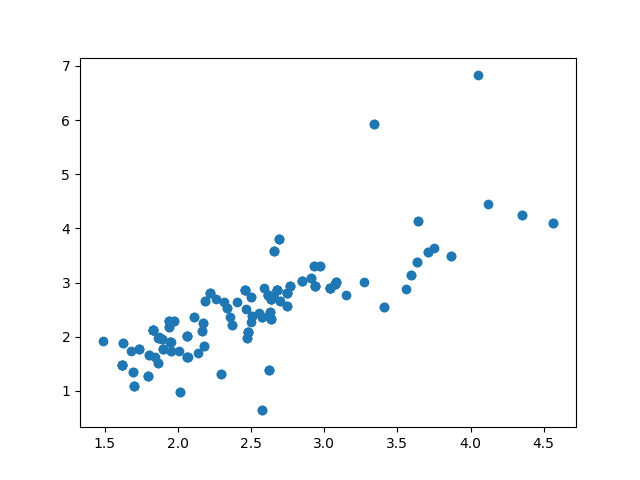

0.6050100179585609


<IPython.core.display.Javascript object>


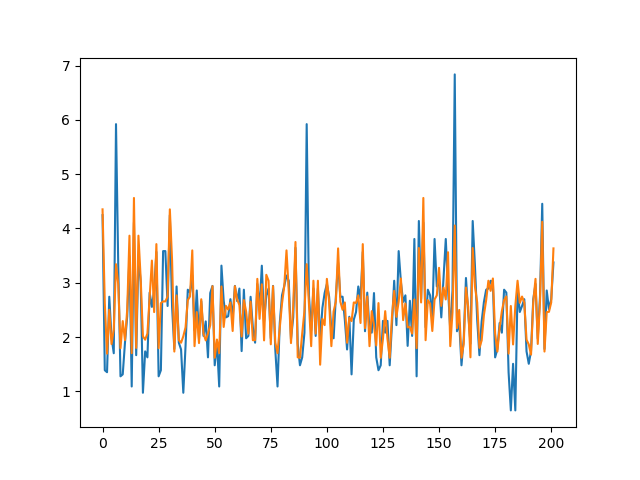

In [82]:
print(Level)
plt.figure()
plt.scatter(Y_hat.mean(axis=0),y_true.mean(axis=0))
print(metrics.r2_score(y_true.mean(axis=0),Y_hat.mean(axis=0)))
plt.figure()
plt.plot(y_true.mean(axis=0))
plt.plot(Y_hat.mean(axis=0))

In [ ]:
depth = 11
Time = time.time()
FirstRun == False
kwit = 0
if __name__ == '__main__':
    for target in ['fco2','fch4']:
        XVarriables=ModSelect(Scope,Site)
        if target == 'fch4' and Site == 'FishIsland':
            XVarriables.append('fco2')
        if FirstRun == True:
            start=1
            stop = len(XVarriables)
            if depth < stop:
                stop = depth
            stop += 2
            try:shutil.rmtree(cwd+'/'+Site+'/'+target+'/')
            except:pass
            os.mkdir(cwd+'/'+Site+'/'+target+'/')
        else:
            params = Dense.Params(Scope,target,MP)
            params['Dpath'] = cwd+'/'+Site+'/'
            Records = pd.read_csv(cwd+'/'+Site+'/'+target+'_Runs.csv',delimiter = ',',header = 0,index_col=[0])
            start = 2#Records['Size'].max()+1
            Level = Records.loc[Records['Size']==start-1]
            Min = Level.loc[Level['MSE']==Level['MSE'].min()]
            Sv = (((Level['SE']**2+Min['SE'].values[0]**2)/2)**.5)
            Level['T']=(Level['MSE']-Min['MSE'].values[0])/(Sv*(2/params['K'])**.5)
            Factors = Level.loc[Level['T']<=stats.t.ppf(1-alpha,params['K']),'Model'].values
            Level.loc[Level['T']<=stats.t.ppf(1-alpha,params['K']),'Performance']=1
            
            stop = len(XVarriables)
            if start >2:
                Last = Records.loc[Records['Size']==start-2].sort_values('MSE').reset_index()
                Rec = Last.loc[Last['MSE']==Last['MSE'].min()]
                Sv = (((Level['SE']**2+Rec['SE'].values[0]**2)/2)**.5)
                Level['T2']=(Level['MSE']-Rec['MSE'].values[0])/(Sv*(2/params['K'])**.5)

                Level.loc[Level['T2']<=-stats.t.ppf(1-alpha,params['K']),'Performance']+=1
                Factors = Level.loc[Level['Performance']>=2,'Model'].values
#             print(Records)
                 
        tar.value=target
        prog1 = FloatProgress(min=start, max=stop,description='Running:')
        prog2 = FloatProgress(min=0, max=100,description='Bootstrapping:')
        MdLs = HTML(
            value=" ",
            placeholder='Models: ',
            description='Models: ',
        )
        MdL = HTML(
            value=" ",
            placeholder='Testing: ',
            description='Testing: ',
        )
        Display (tar,prog1,prog2,MdLs,MdL)

        for j in range(start,stop):
            if j == 1 and Site == 'Illisarvik' and target == 'fco2': Inputs = [['PPFD_Avg']]#(Combos(['PPFD_Avg'],j))
            elif j == 1: Inputs = (Combos(XVarriables,j))
#             print(Inputs)
#             if j == 1: Inputs = (Combos(XVarriables,j))
            else: Inputs = (Combos(XVarriables,j,Factors))
#             print(Inputs,XVarriables,j,Factors)
            MdLs.value=str(len(Inputs))
            i = 0
            procede = True
            for Input in Inputs:
#                 print(Input,start,stop)
                if FirstRun == False:
#                     print(Records.isin({'Size':[j]}).any().any())
                    if Records.loc[Records['Size']==j].isin({'Number':[i]}).any().any()==True:
                        procede = False
                    else:
                        procede = True
                if procede == True:
                    params = Dense.Params(Scope,target,MP)
                    params['Dpath'] = cwd+'/'+Site+'/'
                    params['Spath'] = params['Dpath']+'/'+target+'/'+str(j)+'_'+str(i)+'/'
                    try:os.mkdir(params['Spath'])
                    except:pass
                    params['Sname'] = 'Y_'
                    params['Inputs'] = Input
                    MdL.value='#'+str(i)+' '+str(params['Inputs'])
                    Display (tar,prog1,prog2,MdLs,MdL)
#                     try:
#                         print(Level.sort_values('MSE'))
#                     except:
#                         pass
                    print('Runtime: ',time.time()-Time)
                    params['Model'] = '+'.join(params['Inputs'])
                    RST = RSTF.ReadStandardTimeFill(params,'ECData.csv')#,resample='2H')
                    if target == 'ER':
                        RST.Master = RST.Master.loc[RST.Master['fco2']>0]
                    RST.Scale(params['target'],params['Inputs']) 
                    y = RST.y*1.0
                    X = RST.X*1.0
                    params['N']=int(y.shape[0]/30)
                    params['Memory'] = (math.floor(100/params['proc'])- 5/params['proc']) * .01
                    Y_hat=[]
                    y_true=[]
                    X_true=[]
                    index=[]
                    ones=[]
                    prog2.value=0
                    pool = Pool(processes=processes,maxtasksperchild=75)
                    for k,results in enumerate(pool.imap(partial(Dense.Bootstrap,params=params,X=X,y=y),range(params['K']))):
                        Y_hat.append(RST.YScaled.inverse_transform(results[0]))
                        y_true.append(RST.YScaled.inverse_transform(results[1]))
                        X_true.append(RST.XScaled.inverse_transform(results[2]))
                        ones.append(results[3])
                        prog2.value=(k+1)/params['K']*100
                    pool.close()
                    Y_hat = np.squeeze(np.asanyarray(Y_hat))
                    y_true = np.squeeze(np.asanyarray(y_true))
                    X_true = np.asanyarray(X_true)
                    ones = np.asanyarray(ones)
                    params['Memory'] = .95
#                     if MP == False:
#                         for k in range(1):
#                              mse,se = Dense.Sort_outputs(k,params,Y_hat,y_true,X_true,ones)
#                     else:
                    pool = Pool(processes=1,maxtasksperchild=75)
                    for k,results in enumerate(pool.imap(partial(Dense.Sort_outputs,params=params,
                     Y_hat=Y_hat,y_true=y_true,X_true=X_true,ones=ones),range(1))):
                         mse,se = results
                    pool.close()
                    if i == 0 and FirstRun == True:Level = Stats(mse,se,j,i,params)
                    else:
                        Level = Level.loc[Level['Size']==j]
                        Level = Level.append(Stats(mse,se,j,i,params))
                i += 1
                prog1.value=j+i/len(Inputs)
            Min = Level.loc[Level['MSE']==Level['MSE'].min()]          
            Level.loc[Level['MSE']==Min['MSE'].values[0],'Performance']=1
            Level.loc[Level['MSE']<=Min['MSE'].values[0]+Min['SE'].values[0],'Performance']+=1
            Factors = Level.loc[Level['Performance']>=2,'Model'].values
            print(Factors)
#             if j == 1 and Site == 'Illisarvik' and target == 'fco2':
#                 Factors = ['PPFD_Avg']
            print(Factors,i,j)
            if j == 1:
                Records = Level
            else:
                Records = Records.append(Level)
                
#             kwt.value = str(kwit)
            Records = Records.reset_index(drop=True)
            Records.drop(Records.columns[Records.columns.str.contains('Unnamed',case = False)],axis = 1)
            if Scope == 'Full':
                Records.to_csv(params['Dpath']+'/'+target+'_Runs.csv')
            else:
                Records.to_csv(params['Dpath']+'/'+target+'_Runs2.csv')
#             print(Records)
            if Level['Performance'].max()<2 and j>1:
                break

In [ ]:
# Level.loc[Level['MSE']==Min['MSE'].values[0],'Performance']=1
# Level.loc[Level['MSE']<=Min['MSE'].values[0]+Min['SE'].values[0],'Performance']+=1
# print(Min['MSE'].values[0]+Min['SE'].values[0])
# print(Min)
# print(Level)
print(Records)
Records.to_csv(params['Dpath']+'/'+target+'_Runs.csv')

# print(Factors,start,stop,i,j)

In [ ]:
# print(params)

# Level = Stats(mse,se,j,i,params)
# Level.to_csv(params['Dpath']+target+'_Final_Runs.csv')

# plt.figure()
# print(RST.Master
#      )

# pool = Pool(processes=1,maxtasksperchild=75)
# for k,results in enumerate(pool.imap(partial(Dense.Sort_outputs,params=params,
#  Y_hat=Y_hat,y_true=y_true,X_true=X_true,ones=ones),range(1))):
#      mse,se = results
# pool.close()

# plt.scatter(Y_hat,y_true)
# print(metrics.mean_squared_error(y_true,Y_hat))
# print(metrics.r2_score(y_true,Y_hat))

# plt.figure()

# plt.plot(Y_hat)
# plt.plot(y_true)

# print(Y_hat.shape,y_true.shape)
print(Level)

# Predict

In [ ]:

plt.figure(figsize=(8,7))
Data = Data.sort_values(by=Key)
# Data.index = Data[Key]

Data = Data[np.isfinite(Data['True'])]

plt.scatter(RST.Master[Key],RST.Master[target],edgecolor='black',facecolor='white')
plt.plot(Data[Key],Data[target],
         label= params['target']+' Model\nr^2: '+str(np.round(metrics.r2_score(Data['True'],
                                                                   Data[params['target']])**2,3)))
# plt.plot(Data.index,Data['Var'],label= params['target']+
# ' Model\nRMSE: '+str(np.round(metrics.mean_squared_error(Data['True'],
#                                                                    Data[params['target']])**2,3)))


plt.fill_between(Data[Key], Data[target]-Data['PI'], 
                 Data[target]+Data['PI'],  color = 'green', alpha = 0.4, 
                 label = '95% PI')
plt.fill_between(Data[Key], Data[target]-Data['CI'], 
                 Data[target]+Data['CI'],  color = 'red', alpha = 0.4, 
                 label = '95% CI')
plt.legend()
# print(RST.Master)

plt.figure()

# plt.plot(Data[Key], Data['Var'])

plt.scatter(Data[target],Data['True'])

# print(Data['SE'])